In [2]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, csc_matrix, lil_matrix, dok_matrix, issparse, coo_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp
from collections import Counter

In [3]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def catalan_bonds(): #14 vertices
    """
    Defines the connectivity of a true 14-vertex Catalan molecular structure.

    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
    (0, 4), (0, 6), (0, 12),
    (1, 5), (1, 6), (1, 12),
    (2, 4), (2, 7), (2, 12),
    (3, 5), (3, 7), (3, 12),
    (4, 6), (4, 7), (4, 8), (4, 10), (4, 12), (4, 13),
    (5, 6), (5, 7), (5, 9), (5, 11), (5, 12), (5, 13),
    (6, 8), (6, 9), (6, 12), (6, 13),
    (7, 10), (7, 11), (7, 12), (7, 13),
    (8, 13), (9, 13), (10, 13), (11, 13)
    ]

    return bonds


def transverse_field_ising_catalan(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a Catalan molecular structure.

    Parameters:
        N (int): Number of spins (should match the Catalan molecule, typically N=14).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 14:
        raise ValueError("Catalan molecules typically have N = 14 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)

    # Get Catalan bonds
    bonds = catalan_bonds()

    # Interaction term: J * sigma_i^x * sigma_j^x for Catalan connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def ising_catalan(N, J):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a Catalan molecular structure without transverse field.

    Parameters:
        N (int): Number of spins (should match the Catalan molecule, typically N=14).
        J (float): Interaction strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 14:
        raise ValueError("Catalan molecules typically have N = 14 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)

    # Get Catalan bonds
    bonds = catalan_bonds()

    # Interaction term: J * sigma_i^x * sigma_j^x for Catalan connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    return H

def transverse_field_catalan(N, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a Catalan molecular structure.

    Parameters:
        N (int): Number of spins (should match the Catalan molecule, typically N=14).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 14:
        raise ValueError("Catalan molecules typically have N = 14 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)

    # Get Catalan bonds
    bonds = catalan_bonds()

    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat


def ptrace_sparse(psi_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        psi_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(psi_sparse):
        raise ValueError("psi_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if psi_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    def idx_to_bits(idx):
        return np.array(list(np.binary_repr(idx, width=n))).astype(int)
    

    psi_sparse = psi_sparse.tocoo()
    for i, j, val in zip(psi_sparse.row, psi_sparse.col, psi_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)


        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)


            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)
    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()


def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, subsystem, [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, subsystem, [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy

def entanglement_entropy_qutip(psi, subsystem, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, subsystem)
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [4]:
N = 14  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

keep_qubits = [0,4,5,6,12] #4: [0,4,6,12], #5: [0,4,5,6,12], #6: [0,1,4,5,6,12]

trace_qubits = [i for i in range(N) if i not in keep_qubits]


# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_catalan(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [5]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

# Count the number of (near-)zero components in each eigenvector
zero_threshold = 1e-6
nzero_counts = []
for i in range(eigenvectors.shape[1]):
    num_nzeros = np.sum(np.abs(eigenvectors[:, i]) > zero_threshold)
    nzero_counts.append(num_nzeros)
    print(f"Eigenvector {i}, eigenvalue {eigenvalues[i]}: {num_nzeros} components > {zero_threshold}")

# Optionally, print a summary
print("Zero count distribution:", Counter(nzero_counts))

# Check if each eigenvector is complex or real
for i in range(eigenvectors.shape[1]):
    vec = eigenvectors[:, i]
    #if np.any(np.abs(vec.imag) > 1e-14):
    #    print(f"Eigenvector {i} is complex.")
    #else:
    #    print(f"Eigenvector {i} is real.")

Eigenvalues of H: [-44.21273363 -39.97175698 -39.81697692 ...  43.68466496  49.97958559
  50.08908519]
Eigenvector 0, eigenvalue -44.21273362660148: 7777 components > 1e-06
Eigenvector 1, eigenvalue -39.97175697529948: 8106 components > 1e-06
Eigenvector 2, eigenvalue -39.81697692118247: 7550 components > 1e-06
Eigenvector 3, eigenvalue -39.81697692118247: 7650 components > 1e-06
Eigenvector 4, eigenvalue -39.816976921182416: 7628 components > 1e-06
Eigenvector 5, eigenvalue -39.49429266188303: 6916 components > 1e-06
Eigenvector 6, eigenvalue -39.494292661883016: 7240 components > 1e-06
Eigenvector 7, eigenvalue -37.86656329433191: 7720 components > 1e-06
Eigenvector 8, eigenvalue -37.86656329433189: 7716 components > 1e-06
Eigenvector 9, eigenvalue -37.866563294331876: 7708 components > 1e-06
Eigenvector 10, eigenvalue -37.86613326542614: 7240 components > 1e-06
Eigenvector 11, eigenvalue -36.10477224016074: 7744 components > 1e-06
Eigenvector 12, eigenvalue -36.10477224016074: 7764 

Eigenvector 6297 with eigenvalue -4.0 has 192 non-zero components.
Eigenvector 8272 with eigenvalue -1.9963710269515544e-16 has 368 non-zero components.
Eigenvector 8273 with eigenvalue -2.6183482465524932e-17 has 368 non-zero components.
Eigenvector 8274 with eigenvalue 5.894098962063458e-17 has 368 non-zero components.
Eigenvector 8275 with eigenvalue 1.0447311745392002e-15 has 368 non-zero components.
Indices of sparse eigenvectors: [6297, 8272, 8273, 8274, 8275]


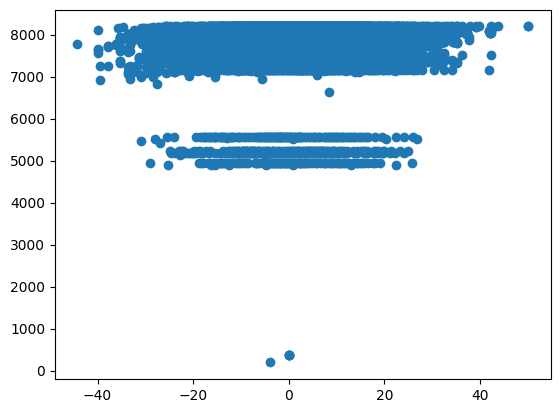

In [6]:
sparse_indices = []
for i in range(eigenvectors.shape[1]):
    if nzero_counts[i] < 2000:
        print(f"Eigenvector {i} with eigenvalue {eigenvalues[i]} has {nzero_counts[i]} non-zero components.")
        sparse_indices.append(i)

print("Indices of sparse eigenvectors:", sparse_indices)

plt.plot(eigenvalues, nzero_counts, 'o')
plt.show()

In [7]:
##################### RDMS + EE #################################

In [15]:
# Analyze eigenvector 6297/8272: expectation values and action of transverse field term

idx = 8272
vec = eigenvectors[:, idx]

# Build Ising icosahedron Hamiltonian (no transverse field)
H_ising = ising_catalan(N, J)

# Build transverse field Hamiltonian only
H_tf = transverse_field_catalan(N, h)

# Compute expectation values
eig_ising = np.vdot(vec, H_ising @ vec)
eig_tf = np.vdot(vec, H_tf @ vec)

print(f"Eigenvector {idx}:")
print(f"  Expectation value w.r.t. Ising icosahedron term: {eig_ising}")
print(f"  Expectation value w.r.t. transverse field term: {eig_tf}")

# Analyze H_tf @ vec
tf_vec = H_tf @ vec
print(f"\nAnalysis of H_tf @ vec for eigenvector {idx}:")
print(f"  Norm: {np.linalg.norm(tf_vec)}")
print(f"  Max abs value: {np.max(np.abs(tf_vec))}")
print(f"  Number of nonzero components (>1e-12): {np.sum(np.abs(tf_vec) > 1e-12)}")
print(f"  Is tf_vec proportional to vec? Ratio: {np.allclose(tf_vec, eig_tf * vec)}")

# Analyze H_ising @ vec
ising_vec = H_ising @ vec
print(f"\nAnalysis of H_ising @ vec for eigenvector {idx}:")
print(f"  Norm: {np.linalg.norm(ising_vec)}")
print(f"  Max abs value: {np.max(np.abs(ising_vec))}")
print(f"  Number of nonzero components (>1e-12): {np.sum(np.abs(ising_vec) > 1e-12)}")
print(f"  Is ising_vec proportional to vec? Ratio: {np.allclose(ising_vec, eig_ising * vec)}")

# Check orthogonality of vec and H_tf @ vec

inner_product = np.vdot(vec, tf_vec)
print(f"Inner product <vec|H_tf|vec>: {inner_product}")
print(f"Is orthogonal (abs(inner_product) < 1e-12)? {np.abs(inner_product) < 1e-12}")

Eigenvector 8272:
  Expectation value w.r.t. Ising icosahedron term: 0.0
  Expectation value w.r.t. transverse field term: 0.0

Analysis of H_tf @ vec for eigenvector 8272:
  Norm: 0.0
  Max abs value: 0.0
  Number of nonzero components (>1e-12): 0
  Is tf_vec proportional to vec? Ratio: True

Analysis of H_ising @ vec for eigenvector 8272:
  Norm: 8.476945232357632e-13
  Max abs value: 4.5123627057108706e-14
  Number of nonzero components (>1e-12): 0
  Is ising_vec proportional to vec? Ratio: True
Inner product <vec|H_tf|vec>: 0.0
Is orthogonal (abs(inner_product) < 1e-12)? True


In [9]:
# scars + tf field - sparse

for i in sparse_indices:
    # Construct the density matrix for each eigenvector (as sparse)
    min_eigenvector = eigenvectors[:, i]
    print("Nonzero elements in state vector (tol=1e-12):", np.sum(np.abs(min_eigenvector) > 1e-6))
    min_eigenvector[np.abs(min_eigenvector) < 1e-7] = 0
    min_eig_sparse = csr_matrix(min_eigenvector.reshape(-1, 1))  # Convert to sparse column vector
    
    # Apply the transverse field operator to the sparse vector
    vecs = transverse_field_catalan(N, h) @ min_eig_sparse
    vecs = vecs.toarray()  # Convert to dense array for further processing
    
    # Print information about the result
    print(f"Shape of result: {vecs.shape}")
    print(f"for {i}-th eigenvector: Number of nonzero elements in result: {np.count_nonzero(vecs)}")
    print(f"Max absolute value in result: {np.max(np.abs(vecs.data))}")

Nonzero elements in state vector (tol=1e-12): 192
Shape of result: (16384, 1)
for 6297-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 368
Shape of result: (16384, 1)
for 8272-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 368
Shape of result: (16384, 1)
for 8273-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 368
Shape of result: (16384, 1)
for 8274-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 368
Shape of result: (16384, 1)
for 8275-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0


In [10]:
# scars + tf field - sparse

for i in sparse_indices:
    # Construct the density matrix for each eigenvector (as sparse)
    min_eigenvector = eigenvectors[:, i]
    print("Nonzero elements in state vector (tol=1e-12):", np.sum(np.abs(min_eigenvector) > 1e-6))
    min_eigenvector[np.abs(min_eigenvector) < 1e-7] = 0
    min_eig_sparse = csr_matrix(min_eigenvector.reshape(-1, 1))  # Convert to sparse column vector

    # Apply the Ising field operator to the sparse vector
    vecs = ising_catalan(N, h) @ min_eig_sparse
    vecs = vecs.toarray()  # Convert to dense array for further processing
    
    # Print information about the result
    print(f"Shape of result: {vecs.shape}")
    print(f"for {i}-th eigenvector: Number of nonzero elements in result: {np.count_nonzero(vecs)}")
    print(f"Max absolute value in result: {np.max(np.abs(vecs.data))}")

Nonzero elements in state vector (tol=1e-12): 192
Shape of result: (16384, 1)
for 6297-th eigenvector: Number of nonzero elements in result: 2425
Max absolute value in result: 0.8660254037844594
Nonzero elements in state vector (tol=1e-12): 368
Shape of result: (16384, 1)
for 8272-th eigenvector: Number of nonzero elements in result: 3790
Max absolute value in result: 1.3539169785303784e-13
Nonzero elements in state vector (tol=1e-12): 368
Shape of result: (16384, 1)
for 8273-th eigenvector: Number of nonzero elements in result: 3791
Max absolute value in result: 9.156564395595979e-14
Nonzero elements in state vector (tol=1e-12): 368
Shape of result: (16384, 1)
for 8274-th eigenvector: Number of nonzero elements in result: 3792
Max absolute value in result: 5.809241976351132e-13
Nonzero elements in state vector (tol=1e-12): 368
Shape of result: (16384, 1)
for 8275-th eigenvector: Number of nonzero elements in result: 3789
Max absolute value in result: 7.283063041541027e-14


In [11]:
# Compute commutator [H_tf, ρ_scar] for each scarred state

H_tf = transverse_field_catalan(N, h)  # Transverse field Hamiltonian (sparse)
commutator_norms = []

for i in sparse_indices:
    scar_vec = eigenvectors[:, i]
    # Density matrix of the scarred state
    rho_scar = np.outer(scar_vec, scar_vec.conj())
    # Convert to sparse for multiplication
    rho_scar_sparse = csr_matrix(rho_scar)
    
    # Compute individual terms
    H_rho = H_tf @ rho_scar_sparse
    rho_H = rho_scar_sparse @ H_tf
    
    # Compute Frobenius norms of individual terms
    H_rho_norm = np.linalg.norm(H_rho.toarray(), ord='fro')
    rho_H_norm = np.linalg.norm(rho_H.toarray(), ord='fro')
    
    # Compute commutator: [H_tf, ρ_scar] = H_tf * ρ_scar - ρ_scar * H_tf
    comm = H_rho - rho_H
    # Compute the Frobenius norm of the commutator
    comm_norm = np.linalg.norm(comm.toarray(), ord='fro')
    commutator_norms.append(comm_norm)
    
    print(f"Scar index {i}:")
    print(f"  ||H_tf * ρ_scar||_F = {H_rho_norm:.3e}")
    print(f"  ||ρ_scar * H_tf||_F = {rho_H_norm:.3e}")
    print(f"  ||[H_tf, ρ_scar]||_F = {comm_norm:.3e}")
    print("-" * 40)

print("All commutator norms:", commutator_norms)

Scar index 6297:
  ||H_tf * ρ_scar||_F = 0.000e+00
  ||ρ_scar * H_tf||_F = 0.000e+00
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 8272:
  ||H_tf * ρ_scar||_F = 0.000e+00
  ||ρ_scar * H_tf||_F = 0.000e+00
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 8273:
  ||H_tf * ρ_scar||_F = 0.000e+00
  ||ρ_scar * H_tf||_F = 0.000e+00
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 8274:
  ||H_tf * ρ_scar||_F = 0.000e+00
  ||ρ_scar * H_tf||_F = 0.000e+00
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
Scar index 8275:
  ||H_tf * ρ_scar||_F = 0.000e+00
  ||ρ_scar * H_tf||_F = 0.000e+00
  ||[H_tf, ρ_scar]||_F = 0.000e+00
----------------------------------------
All commutator norms: [0.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
# Compute commutator [H_tf_sub, RDM] for each scarred state, all in sparse, using ptrace_sparse

def transverse_field_subsystem_sparse(n, h):
    """Transverse field Hamiltonian for n spins (subsystem), sparse."""
    Z = csr_matrix(np.array([[1, 0], [0, -1]]))
    I = identity(2, format="csr")
    H = csr_matrix((2**n, 2**n), dtype=np.complex128)
    for i in range(n):
        ops = [I] * n
        ops[i] = Z
        term = ops[0]
        for op in ops[1:]:
            term = kron(term, op, format="csr")
        H += -h * term
    return H

n_sub = len(keep_qubits)
H_tf_sub_sparse = transverse_field_subsystem_sparse(n_sub, h)

# Compute RDMs for all scarred states using ptrace_sparse (all sparse)
rdms_sparse = []
for i in sparse_indices:
    scar_vec = eigenvectors[:, i]
    scar_vec[np.abs(scar_vec) < 1e-7] = 0
    scar_vec_sparse = csr_matrix(scar_vec.reshape(-1, 1))
    rho_sparse = scar_vec_sparse @ scar_vec_sparse.getH()
    rdm_sparse = ptrace_sparse(rho_sparse, keep_qubits, [2]*N)
    rdms_sparse.append(rdm_sparse)

# Compute commutator norms
commutator_norms_rdm_sparse = []
for idx, rdm in enumerate(rdms_sparse):
    comm = H_tf_sub_sparse @ rdm - rdm @ H_tf_sub_sparse
    comm_norm = np.linalg.norm(comm.toarray(), ord='fro')
    print(f"Scar RDM {idx} (index {idx}): ||[H_tf_sub, RDM]||_F = {comm_norm:.3e}")
    commutator_norms_rdm_sparse.append(comm_norm)

print("All commutator norms for sparse RDMs:", commutator_norms_rdm_sparse)

Scar RDM 0 (index 0): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 1 (index 1): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 2 (index 2): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 3 (index 3): ||[H_tf_sub, RDM]||_F = 0.000e+00
Scar RDM 4 (index 4): ||[H_tf_sub, RDM]||_F = 0.000e+00
All commutator norms for sparse RDMs: [0.0, 0.0, 0.0, 0.0, 0.0]


In [13]:
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []
red_indices = sparse_indices
red_eigenvalues = [eigenvalues[i] for i in red_indices]

for i in tqdm(red_indices):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(red_eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {red_eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

#for i in range(len(red_indices_np)):
#    for j in range(len(red_indices_np)):
#        idx1, idx2 = red_indices_np[i], red_indices_np[j]
#        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
#        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")


 60%|██████    | 3/5 [00:11<00:07,  3.83s/it]


KeyboardInterrupt: 

In [ ]:
half = [2,3,4,5,7,11,12]
# Print selected eigenvalues in red
selected_indices = sparse_indices  # Change this to the indices you want to highlight

for idx in selected_indices:
    print(f"\033[91mEigenvalue[{idx}] = {eigenvalues[idx]}\033[0m")

Eigenvalue[6297] = -4.0
Eigenvalue[8272] = -4.895172808772053e-16
Eigenvalue[8273] = 9.883414851548774e-17
Eigenvalue[8274] = 1.283651141408212e-16
Eigenvalue[8275] = 3.240437212287393e-16


In [ ]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
numpy_entropies = [entanglement_entropy(eigenvectors[:, i], half, N) for i in tqdm(selected_indices)]
#numpy_entropies = [entanglement_entropy(eigenvectors[:, i], half, N) for i in tqdm(range(len(eigenvalues)))]
#qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]
#torch_entropies = [entanglement_entropy_torch(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]

100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


In [ ]:
# Create mid_indices for the 4 innermost eigenvalues in the energy spectrum
sorted_eigenvalues = np.sort(eigenvalues)
mid_energy = (sorted_eigenvalues[0] + sorted_eigenvalues[-1]) / 2

# Find indices of eigenvalues closest to the middle energy
distances_from_mid = np.abs(eigenvalues - mid_energy)
mid_indices = np.argsort(distances_from_mid)[:4].tolist()

print(f"Middle energy: {mid_energy}")
print(f"4 innermost eigenvalue indices: {mid_indices}")
print("4 innermost eigenvalues:")
for idx in mid_indices:
    print(f"\033[92mEigenvalue[{idx}] = {eigenvalues[idx]}\033[0m")

numpy_entropies_mid = [entanglement_entropy(eigenvectors[:, i], half, N) for i in tqdm(mid_indices)]

Middle energy: 2.938175780806077
4 innermost eigenvalue indices: [9775, 9776, 9777, 9778]
4 innermost eigenvalues:
Eigenvalue[9775] = 2.940835653976702
Eigenvalue[9776] = 2.940835653976702
Eigenvalue[9777] = 2.940835653976702
Eigenvalue[9778] = 2.942941367160988


100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Entropies of red points:
Index: 6297, Entropy: 4.792481250360597
Index: 8272, Entropy: 3.2240936677856005
Index: 8273, Entropy: 3.923463928822366
Index: 8274, Entropy: 5.129739383129355
Index: 8275, Entropy: 4.9415772016644075

Entropies of mid points:
Index: 9775, Entropy: 5.900518398186366
Index: 9776, Entropy: 5.895050100972803
Index: 9777, Entropy: 5.93835392208536
Index: 9778, Entropy: 5.943414551896163


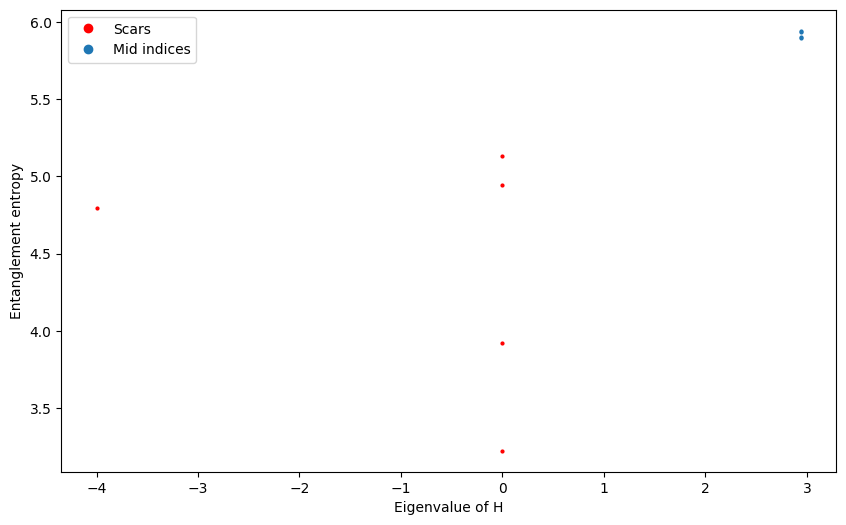

In [ ]:
# Print entropies of red points only
print("Entropies of red points:")
red_entropies = [numpy_entropies[i] for i in range(len(sparse_indices))]
for i in range(len(sparse_indices)):
    print(f'Index: {sparse_indices[i]}, Entropy: {numpy_entropies[i]}')

print("\nEntropies of mid points:")
for i, idx in enumerate(mid_indices):
    print(f'Index: {idx}, Entropy: {numpy_entropies_mid[i]}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Create a mapping from eigenvalue index to entropy for mid indices
mid_entropy_dict = {mid_indices[i]: numpy_entropies_mid[i] for i in range(len(mid_indices))}

# Plot all points first
for i in range(len(eigenvalues)):
    if i in sparse_indices:
        # Red for sparse (scarred) states
        entropy_idx = sparse_indices.index(i)
        plt.plot(eigenvalues[i], numpy_entropies[entropy_idx], 'o', color='red', markersize=2)
    elif i in mid_indices:
        # Blue for mid indices
        plt.plot(eigenvalues[i], mid_entropy_dict[i], 'o', color='C0', markersize=2)

# Add legend
plt.plot([], [], 'o', color='red', label='Scars')
plt.plot([], [], 'o', color='C0', label='Mid indices')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

Entropies of red points:
Index: 6297, Entropy: 6.000000000000005
Index: 8272, Entropy: 5.182155565084527
Index: 8273, Entropy: 5.608495634265154
Index: 8274, Entropy: 6.299114718311577
Index: 8275, Entropy: 5.620052039306026


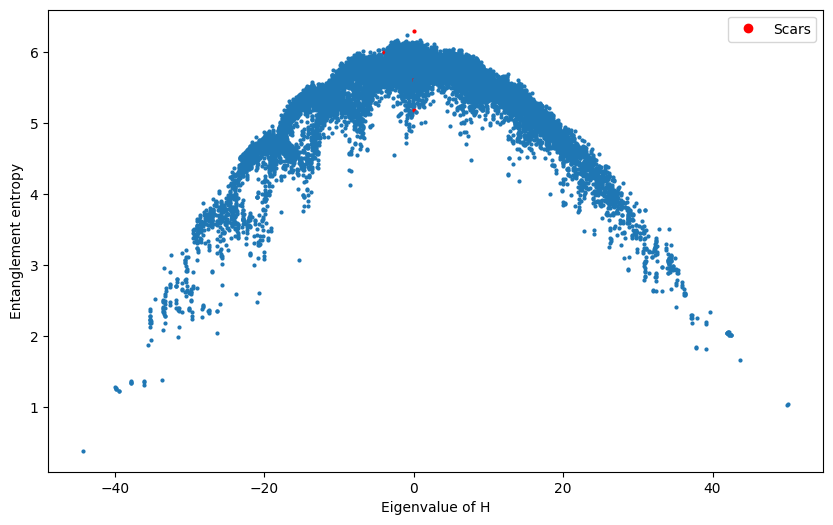

In [ ]:
# Print entropies
print("Entropies of red points:")
red_entropies = [numpy_entropies[i] for i in sparse_indices]
for i in selected_indices:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y in red_entropies else 'C0' for y in numpy_entropies]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

In [ ]:
################## PROPERTIES OF EACH SCARRED STATE AND THEIR RDM ######################

In [ ]:
# List to store the number of dependent columns and their indices for each matrix
dependent_columns_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Perform QR decomposition with column pivoting
    Q, R, pivot_indices = qr(rdm, pivoting=True)
    
    # Determine rank using a threshold on the diagonal of R
    tol = 1e-12
    rank = np.sum(np.abs(np.diag(R)) > tol)
    
    # Calculate the number of dependent columns
    num_dependent_columns = 16 - rank
    
    # Identify dependent columns
    dependent_columns = sorted(set(range(16)) - set(pivot_indices[:rank]))
    dependent_columns_info.append((num_dependent_columns, dependent_columns))
    
    print(f"Number of dependent columns: {num_dependent_columns}")
    print(f"Dependent columns indices: {dependent_columns}")
    print("-" * 50)

# Print the results
print("Dependent columns info for each matrix:", dependent_columns_info)

RDM Index: 0
Number of dependent columns: 8
Dependent columns indices: [0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 14, 15]
--------------------------------------------------
RDM Index: 1
Number of dependent columns: 0
Dependent columns indices: [0, 1, 2, 3, 12, 13, 14, 15]
--------------------------------------------------
RDM Index: 2
Number of dependent columns: 0
Dependent columns indices: [0, 1, 2, 3, 12, 13, 14, 15]
--------------------------------------------------
RDM Index: 3
Number of dependent columns: 0
Dependent columns indices: [0, 1, 2, 3, 12, 13, 14, 15]
--------------------------------------------------
RDM Index: 4
Number of dependent columns: 0
Dependent columns indices: [0, 1, 2, 3, 12, 13, 14, 15]
--------------------------------------------------
Dependent columns info for each matrix: [(np.int64(8), [0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 14, 15]), (np.int64(0), [0, 1, 2, 3, 12, 13, 14, 15]), (np.int64(0), [0, 1, 2, 3, 12, 13, 14, 15]), (np.int64(0), [0, 1, 2, 3, 12, 13, 14, 15]), 

In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        result = np.dot(rdm, basis_vector)
        print(f"RDM {idx}, Null Basis Vector {i}:")
        print(f"Result: {result}")
        print(f"Norm of Result: {np.linalg.norm(result)}")

# Print the results
print("Null space information for each matrix computed.")

RDM Index: 0
Null space dimension: 24
Null space basis vectors:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -7.07106781e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

In [ ]:
# For each RDM, check if any row in its null space basis matrix is (close to) zero
for idx, rdm in enumerate(min_rdms_np):
    null_space_rdm = null_space(rdm)
    for i, row in enumerate(null_space_rdm):
        if np.allclose(row, 0, atol=1e-12):
            print(f"RDM {idx}: Row {i} in null space is (close to) zero.")

RDM 1: Row 4 in null space is (close to) zero.
RDM 1: Row 5 in null space is (close to) zero.
RDM 1: Row 6 in null space is (close to) zero.
RDM 1: Row 7 in null space is (close to) zero.
RDM 1: Row 8 in null space is (close to) zero.
RDM 1: Row 9 in null space is (close to) zero.
RDM 1: Row 10 in null space is (close to) zero.
RDM 1: Row 11 in null space is (close to) zero.
RDM 1: Row 20 in null space is (close to) zero.
RDM 1: Row 21 in null space is (close to) zero.
RDM 1: Row 22 in null space is (close to) zero.
RDM 1: Row 23 in null space is (close to) zero.
RDM 1: Row 24 in null space is (close to) zero.
RDM 1: Row 25 in null space is (close to) zero.
RDM 1: Row 26 in null space is (close to) zero.
RDM 1: Row 27 in null space is (close to) zero.
RDM 2: Row 4 in null space is (close to) zero.
RDM 2: Row 5 in null space is (close to) zero.
RDM 2: Row 6 in null space is (close to) zero.
RDM 2: Row 7 in null space is (close to) zero.
RDM 2: Row 8 in null space is (close to) zero.
RDM

In [ ]:
# Count the number of distinct rows in the null space basis of RDM 0
rdm = min_rdms_np[4]
null_space_rdm = null_space(rdm)

# Use np.allclose to group rows that are numerically identical
distinct_rows = []
for i, row in enumerate(null_space_rdm):
    is_new = True
    for drow in distinct_rows:
        if np.allclose(row, drow, atol=1e-12):
            is_new = False
            break
    if is_new:
        distinct_rows.append(row)

print(f"Number of distinct rows in null space basis of RDM 0: {len(distinct_rows)}")

Number of distinct rows in null space basis of RDM 0: 17


In [ ]:
# Print the binary basis states for each group of identical rows in the null space basis of RDM 0 (5 spins)
# Also print the smallest row index for each group

def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

rdm = min_rdms_np[0]
null_space_rdm = null_space(rdm)

# Group row indices by their unique row (up to numerical tolerance)
groups = []
group_indices = []

for i, row in enumerate(null_space_rdm):
    found = False
    for g, grow in enumerate(groups):
        if np.allclose(row, grow, atol=1e-12):
            group_indices[g].append(i)
            found = True
            break
    if not found:
        groups.append(row)
        group_indices.append([i])

print(f"Number of distinct rows: {len(groups)}")
for indices in group_indices:
    basis_states = [index_to_binary(idx, 5) for idx in indices]
    min_row = min(indices)
    print(f"Row {min_row}: Basis states: {', '.join(basis_states)}")

Number of distinct rows: 28
Row 0: Basis states: 00000
Row 1: Basis states: 00001, 00010
Row 3: Basis states: 00011
Row 4: Basis states: 00100
Row 5: Basis states: 00101
Row 6: Basis states: 00110
Row 7: Basis states: 00111
Row 8: Basis states: 01000
Row 9: Basis states: 01001
Row 10: Basis states: 01010
Row 11: Basis states: 01011
Row 12: Basis states: 01100
Row 13: Basis states: 01101, 01110
Row 15: Basis states: 01111
Row 16: Basis states: 10000
Row 17: Basis states: 10001, 10010
Row 19: Basis states: 10011
Row 20: Basis states: 10100
Row 21: Basis states: 10101
Row 22: Basis states: 10110
Row 23: Basis states: 10111
Row 24: Basis states: 11000
Row 25: Basis states: 11001
Row 26: Basis states: 11010
Row 27: Basis states: 11011
Row 28: Basis states: 11100
Row 29: Basis states: 11101, 11110
Row 31: Basis states: 11111


In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    #print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    #for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        #result = np.dot(rdm, basis_vector)
        #print(f"RDM {idx}, Null Basis Vector {i}:")
        #print(f"Result: {result}")
        #print(f"Norm of Result: {np.linalg.norm(result)}")
    
    # Check for repeating rows in the null space basis vectors
    print(f"Repeating rows in the null space basis vectors for RDM {idx}:")
    for i in range(null_space_rdm.shape[0]):
        for j in range(i + 1, null_space_rdm.shape[0]):
            if np.allclose(null_space_rdm[i, :], null_space_rdm[j, :], atol=1e-12):  # Compare rows with a tolerance
                print(f"Row {i} is identical to Row {j}")
    print("-" * 50)

RDM Index: 0
Null space dimension: 24
--------------------------------------------------
Repeating rows in the null space basis vectors for RDM 0:
Row 1 is identical to Row 2
Row 13 is identical to Row 14
Row 17 is identical to Row 18
Row 29 is identical to Row 30
--------------------------------------------------
RDM Index: 1
Null space dimension: 16
--------------------------------------------------
Repeating rows in the null space basis vectors for RDM 1:
Row 4 is identical to Row 5
Row 4 is identical to Row 6
Row 4 is identical to Row 7
Row 4 is identical to Row 8
Row 4 is identical to Row 9
Row 4 is identical to Row 10
Row 4 is identical to Row 11
Row 4 is identical to Row 20
Row 4 is identical to Row 21
Row 4 is identical to Row 22
Row 4 is identical to Row 23
Row 4 is identical to Row 24
Row 4 is identical to Row 25
Row 4 is identical to Row 26
Row 4 is identical to Row 27
Row 5 is identical to Row 6
Row 5 is identical to Row 7
Row 5 is identical to Row 8
Row 5 is identical to R

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    # Print the entire eigenvector
    non_zero_count = 0  # Counter for non-zero components
    print(f"Full Eigenvector {i}:")
    for index, component in enumerate(eigenvector):
        # Set components of the order 10^-12 or smaller to zero
        if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
            eigenvector[index] = 0.0
        else:
            non_zero_count += 1
        binary_basis = index_to_binary(index, N)
        print(f"{binary_basis}: {eigenvector[index]}")

    print(f"Total Non-Zero Components in Scarred Eigenvector {i}: {non_zero_count}")
    print("=" * 50)

Full Eigenvector 0:
00000000000000: 0.9300813511256176
00000000000001: 0.0
00000000000010: 0.0
00000000000011: 0.01765401759083468
00000000000100: 0.0
00000000000101: -0.062380469277862394
00000000000110: 0.010139365491688285
00000000000111: 0.0
00000000001000: 0.0
00000000001001: -0.062380469277862435
00000000001010: 0.010139365491688266
00000000001011: 0.0
00000000001100: 0.017029533892663165
00000000001101: 0.0
00000000001110: 0.0
00000000001111: -0.0012692429176628722
00000000010000: 0.0
00000000010001: -0.062380469277862435
00000000010010: 0.010139365491688266
00000000010011: 0.0
00000000010100: 0.017029533892663158
00000000010101: 0.0
00000000010110: 0.0
00000000010111: -0.0012692429176628724
00000000011000: 0.005862681867654806
00000000011001: 0.0
00000000011010: 0.0
00000000011011: -0.0014722294599080015
00000000011100: 0.0
00000000011101: -0.0018239688275784962
00000000011110: 0.0004722125677026627
00000000011111: 0.0
00000000100000: 0.0
00000000100001: -0.06238046927786244
00

KeyboardInterrupt: 

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")
    
    # Dictionary to track processed coefficients
    processed_coeffs = set()
    
    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component
            
            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue
            
            # Count the number of 1's in the binary representation
            num_ones = binary_basis.count('1')
            
            # Print the coefficient, binary representation, and number of 1's
            print(f"  Coefficient: {coeff}")
            print(f"    Binary Representation: {binary_basis}")
            print(f"    Elements [0, 4, 5, 9]: {binary_basis[0]}, {binary_basis[4]}, {binary_basis[5]}, {binary_basis[9]}")
            print(f"    Number of 1's: {num_ones}")
            
            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)
                    num_ones_neg = binary_basis_neg.count('1')
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Elements [0, 4, 5, 9]: {binary_basis_neg[0]}, {binary_basis_neg[4]}, {binary_basis_neg[5]}, {binary_basis_neg[9]}")
                    print(f"    Number of 1's: {num_ones_neg}")
                    break
            
            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)
    
    print("=" * 50)

In [ ]:
# List to store even swaps numbers
even_swaps_numbers = []

# Dictionary to track spin exchange arrays and their counts
spin_exchange_counts = {}

# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")

    # Dictionary to track processed coefficients
    processed_coeffs = set()

    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component

            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue

            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)

                    # Identify the spins that are exchanged
                    spin_exchange = [
                        k for k in range(N) if binary_basis[k] != binary_basis_neg[k]
                    ]

                    # Compute swaps number
                    swaps_number = len(spin_exchange) // 2

                    # Check if swaps number is odd
                    is_odd = swaps_number % 2 == 1

                    print(f"  Coefficient: {coeff}")
                    print(f"    Binary Representation: {binary_basis}")
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Spin Exchange: {spin_exchange}")
                    print(f"    Swaps Number: {swaps_number} (Odd: {is_odd})")

                    # Add to even swaps numbers if swaps number is even
                    if not is_odd:
                        even_swaps_numbers.append(swaps_number)

                    # Track spin exchange arrays
                    spin_exchange_tuple = tuple(spin_exchange)
                    if spin_exchange_tuple in spin_exchange_counts:
                        spin_exchange_counts[spin_exchange_tuple] += 1
                    else:
                        spin_exchange_counts[spin_exchange_tuple] = 1

                    break

            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)

    print("=" * 50)

# Print the list of even swaps numbers
print("Even swaps numbers:", even_swaps_numbers)

# Check for repeated spin exchange arrays
repeated_spin_exchanges = [
    spin_exchange for spin_exchange, count in spin_exchange_counts.items() if count > 1
]
if repeated_spin_exchanges:
    print("Repeated spin exchange arrays:", repeated_spin_exchanges)
else:
    print("No repeated spin exchange arrays found.")

print(len(spin_exchange_counts), "spin exchange arrays found.")

In [ ]:
# min_scar

non_zero_count = 0  # Counter for non-zero components

for index, component in enumerate(min_scar):
    # Set components of the order 10^-12 or smaller to zero
    if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
        min_scar[index] = 0.0
    else:
        non_zero_count += 1
    binary_basis = index_to_binary(index, N)
    print(f"{binary_basis}: {np.real(min_scar[index])}")

print(f"Total Non-Zero Components in min_scar: {non_zero_count}")
print("=" * 50)

In [ ]:
# check if other states have 280 non-zero components - it's only the 5 scars!

# Count distinct non_zero_count values
distinct_counts = set()

# Counter to track occurrences of each non_zero_count
non_zero_count_occurrences = Counter()

# Iterate over all eigenvectors
for i in range(eigenvectors.shape[1]):
    eigenvector = eigenvectors[:, i]
    non_zero_count = 0  # Counter for non-zero components
    
    # Count non-zero components
    for component in eigenvector:
        if np.abs(component) >= 1e-12:
            non_zero_count += 1
    
    # Update the counter
    non_zero_count_occurrences[non_zero_count] += 1
    print(f"Total Non-Zero Components in Eigenvector {i}: {non_zero_count}")

# Print the number of distinct non_zero_count values
print(f"Number of distinct non_zero_count values: {len(non_zero_count_occurrences)}")
print(f"Distinct non_zero_count values: {sorted(non_zero_count_occurrences.keys())}")

# Print how many times each distinct non_zero_count appears
print("Occurrences of each non_zero_count:")
for count, occurrences in sorted(non_zero_count_occurrences.items()):
    print(f"Non-Zero Count: {count}, Occurrences: {occurrences}")